# Load Libraries

In [17]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import gensim  # para cargar modelo w2v
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model

# Load Data

In [2]:
#Read Data
data = pd.read_csv("deceptive-opinion.csv", usecols=['polarity','text'])
data.head(10)

,polarity,text
0,positive,We stayed for a one night getaway with family ...
1,positive,Triple A rate with upgrade to view room was le...
2,positive,This comes a little late as I'm finally catchi...
3,positive,The Omni Chicago really delivers on all fronts...
4,positive,I asked for a high floor away from the elevato...
5,positive,I stayed at the Omni for one night following a...
6,positive,We stayed in the Conrad for 4 nights just befo...
7,positive,Just got back from 2 days up in Chicago shoppi...
8,positive,We arrived at the Omni on 2nd September for a ...
9,positive,"On our visit to Chicago, we chose the Hyatt du..."


# Data Preprocessing

In [3]:

# Function to remove punctuation and numbers
def remove_puntuacion(text):
  """Remove puntuación and numbers"""
  new_text = re.sub('[^a-z]+', ' ', text)  
  return new_text   

In [4]:
# Convert text to lower case and remove punctuation
data['text'] = data['text'].str.lower()
data['text_p'] = data['text'].apply(remove_puntuacion)
# Get lenght of each text review
data['text_len'] = data['text_p'].str.split().str.len()
data.head(10)
     

,polarity,text,text_p,text_len
0,positive,we stayed for a one night getaway with family ...,we stayed for a one night getaway with family ...,106
1,positive,triple a rate with upgrade to view room was le...,triple a rate with upgrade to view room was le...,43
2,positive,this comes a little late as i'm finally catchi...,this comes a little late as i m finally catchi...,209
3,positive,the omni chicago really delivers on all fronts...,the omni chicago really delivers on all fronts...,126
4,positive,i asked for a high floor away from the elevato...,i asked for a high floor away from the elevato...,73
5,positive,i stayed at the omni for one night following a...,i stayed at the omni for one night following a...,177
6,positive,we stayed in the conrad for 4 nights just befo...,we stayed in the conrad for nights just before...,107
7,positive,just got back from 2 days up in chicago shoppi...,just got back from days up in chicago shopping...,126
8,positive,we arrived at the omni on 2nd september for a ...,we arrived at the omni on nd september for a d...,163
9,positive,"on our visit to chicago, we chose the hyatt du...",on our visit to chicago we chose the hyatt due...,85


In [5]:
# Get Vocabulary from hotel reviews
def vocabulary(pandas_series):
    word_list = " ".join(sec for sec in pandas_series).split(" ")
    x = Counter(word_list)

    return [i for i,_ in x.most_common() ]

vocabulary_words = vocabulary(data['text_p'])
vocabulary_words

['the',
 'and',
 'to',
 'i',
 'a',
 'was',
 'in',
 'hotel',
 'of',
 'we',
 'for',
 'room',
 'it',
 'at',
 'my',
 'is',
 'that',
 'with',
 'not',
 'were',
 'had',
 'this',
 'on',
 '',
 'chicago',
 'but',
 'they',
 'our',
 'very',
 'stay',
 'have',
 'you',
 'there',
 't',
 'be',
 'as',
 'from',
 'when',
 'would',
 'all',
 'so',
 'great',
 'staff',
 'me',
 'service',
 'are',
 'one',
 'rooms',
 'stayed',
 'out',
 'an',
 's',
 'no',
 'up',
 'night',
 'us',
 'if',
 'like',
 'get',
 'just',
 'will',
 'time',
 'desk',
 'about',
 'again',
 'or',
 'nice',
 'location',
 'after',
 'even',
 'did',
 'which',
 'by',
 'bed',
 'could',
 'only',
 'here',
 'also',
 'clean',
 'what',
 'good',
 'got',
 'front',
 'back',
 'more',
 'their',
 'check',
 'well',
 'some',
 'place',
 'been',
 'first',
 'day',
 'bathroom',
 'can',
 'experience',
 'next',
 'other',
 'than',
 'two',
 'really',
 'friendly',
 'because',
 'comfortable',
 'never',
 'made',
 'hotels',
 'go',
 'didn',
 'recommend',
 'business',
 'has',
 '

In [6]:
# Count vocabulary  Unique words
len(vocabulary_words)

9309

In [7]:
#Map words to tokens and numeric values


def get_dict_map(token_or_tag):
    if token_or_tag == 'token':
        # agregamos 'PAD_token' al vocabulario de tokens, para ser usado más
        # adelante a fin de que todas las oraciones tengan la misma cantidad de
        # tokens
        vocab = ['PAD_token'] + [token for token in vocabulary(data['text_p']) if token is not None] 
    elif token_or_tag == 'tag':
        vocab = vocabulary(data['Tags'])

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map('token')
print(token2idx['PAD_token'])
print(len(token2idx))   


0
9310


In [8]:
# Map tokes to numeric values
data['text_idx'] = data['text_p'].apply(lambda x: list(map(token2idx.get, x.split())))

<Axes: >

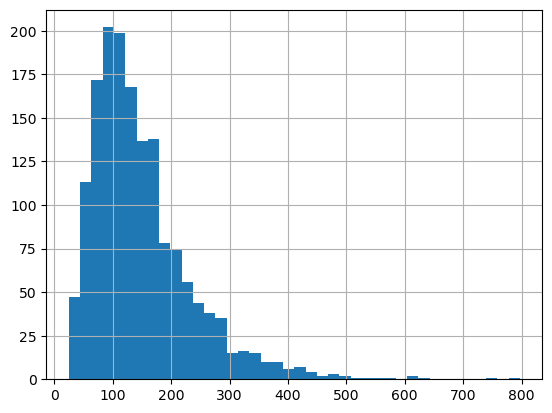

In [9]:
#Histogram with reviews lenght
data['text_len'].hist(bins=40) 

In [10]:
# Estimate percentiles for the variable text_len
custom_percentiles = list(range(5, 101,5))
custom_percentile_values = np.percentile(data['text_len'], custom_percentiles)
percentile_table = pd.DataFrame({
    'Percentile': custom_percentiles,
    'Value': custom_percentile_values
})
print(percentile_table)

    Percentile   Value
0            5   52.00
1           10   63.90
2           15   72.00
3           20   81.00
4           25   89.00
5           30   98.00
6           35  105.00
7           40  113.00
8           45  120.55
9           50  128.00
10          55  138.45
11          60  149.00
12          65  161.00
13          70  171.30
14          75  183.00
15          80  203.00
16          85  228.00
17          90  262.00
18          95  316.00
19         100  797.00


In [11]:
# Define max lenght for reviews
max_len = int(data['text_len'].quantile(0.95))
max_len

316

In [12]:
#View Data
data.head(10)

,polarity,text,text_p,text_len,text_idx
0,positive,we stayed for a one night getaway with family ...,we stayed for a one night getaway with family ...,106,"[10, 49, 11, 5, 47, 55, 685, 18, 237, 23, 5, 1..."
1,positive,triple a rate with upgrade to view room was le...,triple a rate with upgrade to view room was le...,43,"[2792, 5, 283, 18, 596, 3, 115, 12, 6, 411, 99..."
2,positive,this comes a little late as i'm finally catchi...,this comes a little late as i m finally catchi...,209,"[22, 1079, 5, 213, 385, 36, 4, 238, 187, 3904,..."
3,positive,the omni chicago really delivers on all fronts...,the omni chicago really delivers on all fronts...,126,"[1, 321, 25, 101, 3251, 23, 40, 3906, 37, 1, 5..."
4,positive,i asked for a high floor away from the elevato...,i asked for a high floor away from the elevato...,73,"[4, 161, 11, 5, 222, 122, 170, 37, 1, 452, 2, ..."
5,positive,i stayed at the omni for one night following a...,i stayed at the omni for one night following a...,177,"[4, 49, 14, 1, 321, 11, 47, 55, 1306, 5, 111, ..."
6,positive,we stayed in the conrad for 4 nights just befo...,we stayed in the conrad for nights just before...,107,"[10, 49, 7, 1, 347, 11, 176, 60, 157, 2797, 10..."
7,positive,just got back from 2 days up in chicago shoppi...,just got back from days up in chicago shopping...,126,"[60, 82, 84, 37, 269, 54, 7, 25, 205, 18, 2043..."
8,positive,we arrived at the omni on 2nd september for a ...,we arrived at the omni on nd september for a d...,163,"[10, 136, 14, 1, 321, 23, 976, 1244, 11, 5, 93..."
9,positive,"on our visit to chicago, we chose the hyatt du...",on our visit to chicago we chose the hyatt due...,85,"[23, 28, 208, 3, 25, 10, 618, 1, 338, 586, 3, ..."


In [13]:
# Check for None values within column text_idx
print("\nConcise check for None within lists in data['text_idx']:")
has_none = False
for index, text_indices in data['text_idx'].items():
    if isinstance(text_indices, list) and any(value is None for value in text_indices):
        print(f"List at DataFrame index {index} contains None values.")
        print(data.loc[index]['text_p'])
        has_none = True
    elif text_indices is None:
        print(f"The entire entry at DataFrame index {index} is None")
        has_none = True

if not has_none:
    print("\nNo None values found within the lists in data['text_idx'].")


Concise check for None within lists in data['text_idx']:

No None values found within the lists in data['text_idx'].


In [14]:
# Padding, add Pad Token to make reviews of the same length
pad_tokens = pad_sequences(data['text_idx'], maxlen= max_len,
                           dtype='int32', padding='post',
                           value = token2idx['PAD_token'])

# Use trained Word2Vec to map words into vectors

In [ ]:
# Load Word2Vec
file =  '/home/ola/Documents/ubuntu/mydsportafolio/rnn_classifier/notes/GoogleNews-vectors-negative300.bin.gz'
w2v = gensim.models.KeyedVectors.load_word2vec_format(file,  binary=True)
vocabulary = word_vectors.index_to_key

In [ ]:
#Explore word2vec
print('Words in model w2v: {:,} '.format(len(w2v.vocab)))
print('Words in model w2v: {:,} '.format(len(w2v.key_to_index)))
print('Dimensions for embedding: ', w2v.vector_size)   


AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4